In [255]:
%load_ext autoreload
%autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# common library
import pandas as pd
import numpy as np
import time
from stable_baselines.common.vec_env import DummyVecEnv
import matplotlib.pyplot as plt

# preprocessor
from preprocessing.preprocessors import preprocess_data, data_split
# config
from config.config import *
# model
from model.models import *
import os


# read and preprocess data
preprocessed_path = "processed_stock_source_data.csv"
if os.path.exists(preprocessed_path):
    data = pd.read_csv(preprocessed_path, index_col=0)
else:
    data = preprocess_data()
    data.to_csv(preprocessed_path)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/Users/andrasrabai/Dissertation/new_code/FinRL-Trading/.venv/lib/python3.6/site-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [34]:
unique_trade_dates = data[(data.datadate > 20151001) & (data.datadate <= 20200707)].datadate.unique()
iter_num = 1197
df = data
rebalance_window = 63
trading_data = data_split(df, start=unique_trade_dates[iter_num - rebalance_window], end=unique_trade_dates[iter_num] + 1)
k =1 
pd.Series(trading_data.datadate.unique()[k:]).agg([min, max])

min    20200407
max    20200707
dtype: int64

In [8]:
def process_trading_results(model_name):
    """
    Processes trading results

    Parameters:
    -----------
    model_name: str
        name of the model (e.g. A2C_default)

    Returns:
    --------
    pd.DataFrame
        A pivot table for account values with datadate as the index and subfolder names as columns.
    """
    run_trading_results = {}

    model_folder = os.path.join('results', model_name)
    for subfolder in os.listdir(model_folder):
        subfolder_path = os.path.join(model_folder, subfolder)

        # check if it's a folder indeed with a numeric name
        if os.path.isdir(subfolder_path) and subfolder.isdigit():
            trading_results_df = pd.DataFrame()

            # iterate through files in the subfolder
            for file in os.listdir(subfolder_path):
                # process only such csv files that contain trading data and are for the given model
                if file.startswith(f'account_value_trade_{model_name}') and file.endswith('.csv'):
                    file_path = os.path.join(subfolder_path, file)

                    # read the CSV file
                    df = pd.read_csv(file_path, usecols=['datadate', 'account_values'])

                    # combine the trading snapshot with existing outputs
                    if trading_results_df.empty:
                        trading_results_df = df
                    else:
                        trading_results_df = pd.concat([trading_results_df, df], axis=0)

            trading_results_df.insert(0, 'run_id', int(subfolder))
            # check if any duplicates
            assert (
                len(trading_results_df) == len(trading_results_df.drop_duplicates())
            ), f'duplicated entries found in trading data for model "{model_name}"'

            # store the the results
            run_trading_results[int(subfolder)] = trading_results_df

    if len(run_trading_results) > 0:
        combined_df = pd.concat(run_trading_results.values()).reset_index(drop=True)
        combined_pivot = combined_df.pivot_table(
            index='datadate', columns='run_id', values='account_values'
        )
        # change dtype of datadate from int to datetime64
        return combined_pivot.set_index(pd.to_datetime(combined_pivot.index, format='%Y%m%d'))
    

def process_turbulence_history(model_name):
    """
    Processes turbulence history

    Parameters:
    -----------
    model_name: str
        name of the model (e.g. A2C_default)

    Returns:
    --------
    pd.DataFrame
        A pivot table for account values with datadate as the index and subfolder names as columns.
    """
    run_trading_results = {}

    model_folder = os.path.join('results', model_name)
    for subfolder in os.listdir(model_folder):
        subfolder_path = os.path.join(model_folder, subfolder)

        # check if it's a folder indeed with a numeric name
        if os.path.isdir(subfolder_path) and subfolder.isdigit():
            turbulence_df = pd.DataFrame()

            # iterate through files in the subfolder
            for file in os.listdir(subfolder_path):
                # process only such csv files that contain trading data and are for the given model
                if file.startswith(f'turbulence_history_{model_name}') and file.endswith('.csv'):
                    file_path = os.path.join(subfolder_path, file)

                    # read the CSV file
                    df = pd.read_csv(file_path)
                    df.columns = ['datadate', 'turbulence_level', 'turbulence_threshold', 'is_above_threshold']
                    df.datadate = pd.to_datetime(df.datadate, format='%Y%m%d')

                    # combine the trading snapshot with existing outputs
                    if turbulence_df.empty:
                        turbulence_df = df
                    else:
                        turbulence_df = pd.concat([turbulence_df, df], axis=0).sort_values(by='datadate')

            # check if any duplicates
            assert (
                len(turbulence_df) == len(turbulence_df.drop_duplicates())
            ), f'duplicated entries found in trading data for model "{model_name}"'

            break  # turbulence history is shared across all runs

    return turbulence_df
    #if len(run_trading_results) > 0:
    #    combined_df = pd.concat(run_trading_results.values()).reset_index(drop=True)
    #    combined_pivot = combined_df.pivot_table(
    #        index='datadate', columns='run_id', values='account_values'
    #    )
    #    # change dtype of datadate from int to datetime64
    #    return combined_pivot.set_index(pd.to_datetime(combined_pivot.index, format='%Y%m%d'))

In [9]:
import pyfolio as pf
import pandas as pd

def calculate_single_stats(ser):
    """
    calculates summary statistics for a single run

    Parameters:
    -----------
    series pd.Series
        pd.Series with floating values and a datatime index

    Returns:
    --------
    dict: A dictionary containing cumulative return, annual return, annual volatility,
        Sharpe ratio, and max drawdown
    """
    # Use pyfolio to calculate performance metrics
    perf_stats = pf.timeseries.perf_stats(ser.pct_change().dropna())

    perf_stats = pd.DataFrame(perf_stats, columns=[ser.name])
    mask = perf_stats.index.isin(
        ['Cumulative returns', 'Annual return', 'Annual volatility', 'Sharpe ratio', 'Max drawdown']
    )
    return perf_stats[mask]

def calculate_average_stats(df):
    """
    calculates averaged summary statistics over multiple runs

    Parameters:
    -----------
    df pd.DataFrame
        pd.DataFrame with floating values in many columns and a datatime index

    Returns:
    --------
    dict: A dictionary containing cumulative return, annual return, annual volatility,
        Sharpe ratio, and max drawdown
    """
    all_stats = []

    for col in df.columns:
        single_run_stats = calculate_single_stats(df[col])
        all_stats.append(single_run_stats)

    avg_stats = pd.concat(all_stats, axis=1).mean(axis=1)
    return avg_stats

/Users/andrasrabai/Dissertation/new_code/FinRL-Trading/.venv/lib/python3.6/site-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [ ]:
### Plot 

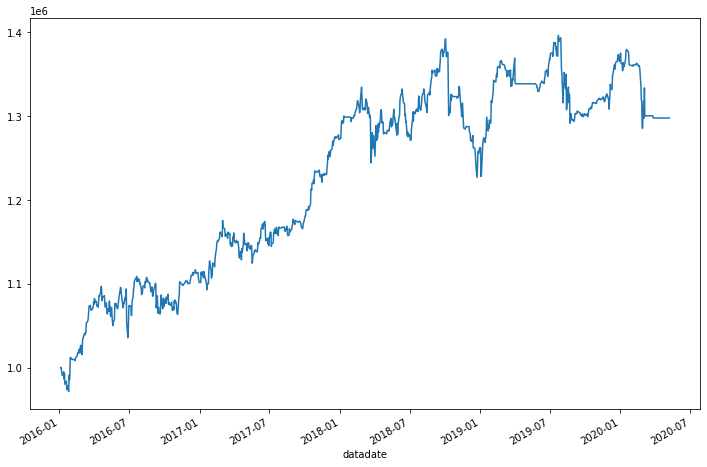

In [ ]:
plt.figure(figsize=(12, 8))
combined_pivot = process_trading_results('test')
combined_pivot[combined_pivot.index <= pd.to_datetime('2020-05-08', format='%Y-%m-%d')][1].plot()

In [499]:
calculate_single_stats(combined_pivot.iloc[:, 1])
all_stats = calculate_average_stats(combined_pivot)
all_stats

Annual return         0.098837
Cumulative returns    0.532369
Annual volatility     0.126069
Sharpe ratio          0.812160
Max drawdown         -0.165488
dtype: float64

In [510]:
n = 1133 / 250
(1 + all_stats.loc['Annual return'])**n


1.5328844073749281

### Visualising single (Sharpe) results *averaged* over 30 runs

In [462]:
%matplotlib inline

average_stats = {}
run_stats = {}
model_names = [
    # A2C
    'A2C_MLP_default_relu_TL140', 'A2C_MLP_default_tanh_TL140', 'A2C_MLP_default_leaky_relu_TL140',
    'A2C_MLP_wider_relu_TL140', 'A2C_MLP_wider_tanh_TL140', 'A2C_MLP_wider_leaky_relu_TL140',
    'A2C_MLP_shallower_relu_TL140', 'A2C_MLP_shallower_tanh_TL140', 'A2C_MLP_shallower_leaky_relu_TL140',
    'A2C_MLP_deeper_relu_TL140', 'A2C_MLP_deeper_tanh_TL140', 'A2C_MLP_deeper_leaky_relu_TL140',
    
    # DDPG
    'DDPG_MLP_default_relu_TL140', 'DDPG_MLP_default_tanh_TL140', 'DDPG_MLP_default_leaky_relu_TL140',
    'DDPG_MLP_wider_relu_TL140', 'DDPG_MLP_wider_tanh_TL140', 'DDPG_MLP_wider_leaky_relu_TL140',
    'DDPG_MLP_shallower_relu_TL140', 'DDPG_MLP_shallower_tanh_TL140', 'DDPG_MLP_shallower_leaky_relu_TL140',
    'DDPG_MLP_deeper_relu_TL140', 'DDPG_MLP_deeper_tanh_TL140', 'DDPG_MLP_deeper_leaky_relu_TL140',

    # PPO
    'PPO_MLP_default_relu_TL140', 'PPO_MLP_default_tanh_TL140', 'PPO_MLP_default_leaky_relu_TL140',
    'PPO_MLP_wider_relu_TL140', 'PPO_MLP_wider_tanh_TL140', 'PPO_MLP_wider_leaky_relu_TL140',
    'PPO_MLP_shallower_relu_TL140', 'PPO_MLP_shallower_tanh_TL140', 'PPO_MLP_shallower_leaky_relu_TL140',
    'PPO_MLP_deeper_relu_TL140', 'PPO_MLP_deeper_tanh_TL140', 'PPO_MLP_deeper_leaky_relu_TL140',
]

for model_name in model_names:
    show_above_threshold_turbulence = True

    fig, ax = plt.subplots(figsize=(14, 8))

    combined_pivot = process_trading_results(model_name)
    turbulence_history = process_turbulence_history(model_name)

    # plot individual runs
    for run in combined_pivot.columns:
        ax.plot(combined_pivot[run], label=f'Run={run}', alpha=0.6)
        if run_stats.get(model_name) is None:
            run_stats[model_name] = [calculate_single_stats(combined_pivot[run])]
        else:
            run_stats[model_name].append(calculate_single_stats(combined_pivot[run]))

    # plot average run
    ax.plot(combined_pivot.mean(axis=1), label='Average', c='k', lw=2)

    # plot date ranges with excessive (above threshold) turbulence
    if show_above_threshold_turbulence:
        turbulence_history['group'] = (
            turbulence_history['is_above_threshold'] != turbulence_history['is_above_threshold'].shift(1)
        ).cumsum()
        first_label = True
        for group in turbulence_history.group.unique():
            filtered = turbulence_history[turbulence_history.group == group]
            flag = filtered.is_above_threshold.unique()[0]
            if flag:
                start_date, end_date = filtered.datadate.agg([min, max])
                ax.axvspan(start_date, end_date, color='pink', alpha=0.3, label='excessive turbulence' if first_label else '')
                first_label = False
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel('Account value')
    plt.xlabel('Date')
    plt.title(f'Trading results | model={model_name}')
    plt.savefig(f'{model_name}.png')
    plt.close()
    average_stats[model_name] = calculate_average_stats(combined_pivot)

# reformatting results
results = {}
for model_name in model_names:
    x = pd.Series([
        model_name.split('_')[0], '_'.join(model_name.split('_')[1:3]),
        '_'.join(model_name.split('_')[3:-1]), model_name.split('_')[-1][2:]
    ],
    index=[
        'Model name', 'Architecture',
        'Activation function', 'Turbulence threshold'
    ])
    results[model_name] = pd.concat([x, average_stats[model_name]])
results_df = pd.DataFrame(results).T.sort_values(by='Cumulative returns', ascending=False)
for col in results_df.columns[3:]:
    results_df[col] = results_df[col].astype(int if col == 'Turbulence threshold' else float)


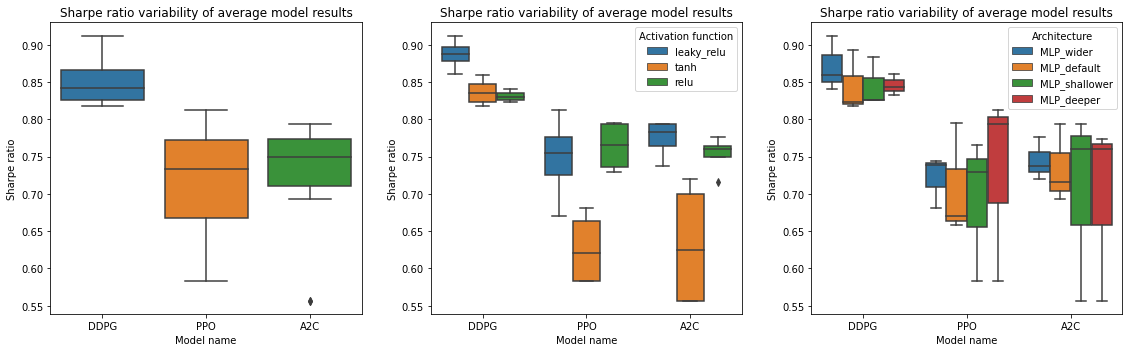

In [14]:
import seaborn as sns
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs = axs.flatten()
title = 'Sharpe ratio variability of average model results'
sns.boxplot(data=results_df, x='Model name', y='Sharpe ratio', ax=axs[0]).set_title(title)
sns.boxplot(data=results_df, x='Model name', y='Sharpe ratio', hue='Activation function', ax=axs[1]).set_title(title)
sns.boxplot(data=results_df, x='Model name', y='Sharpe ratio', hue='Architecture', ax=axs[2]).set_title(title)
plt.tight_layout()

### Visualising the dispersion of runs (30) for each model | Cumulative Returns + Sharpe 

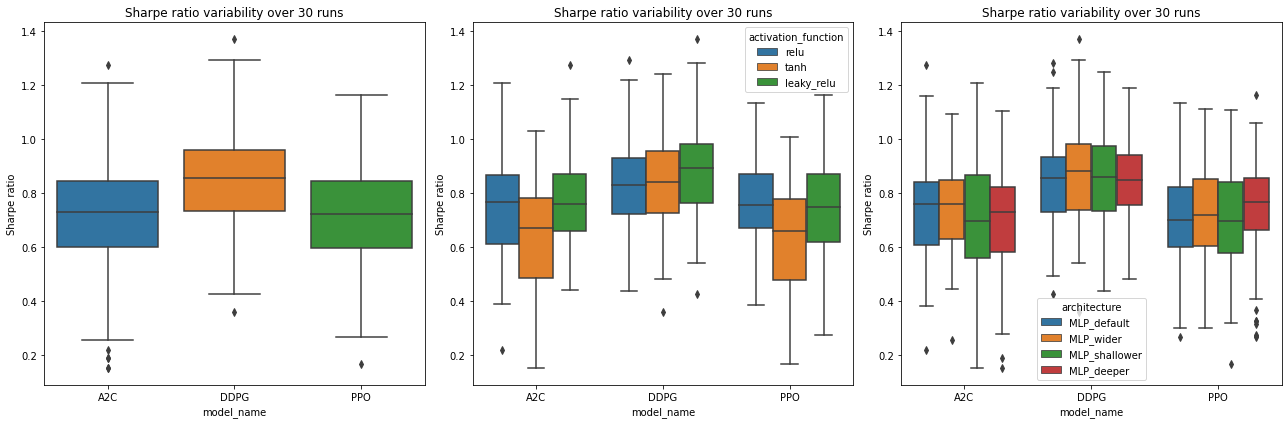

In [99]:
import seaborn as sns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs = axs.flatten()

for n, col in enumerate(['Sharpe ratio']): #enumerate(['Cumulative returns', 'Sharpe ratio', 'Annual volatility']):
    run_df = (
        pd.DataFrame(run_stats).applymap(lambda x: float(x.loc[col].values[0]))
                            .T
                            .reset_index(drop=False)
                            .rename(columns={'index': 'model_long_name'})
    )
    run_df.insert(1, 'model_name', run_df['model_long_name'].str.split('_').str.get(0))
    run_df.insert(2, 'architecture', (run_df['model_long_name'].str.split('_').str[1:3]).str.join('_'))
    run_df.insert(3, 'activation_function', (run_df['model_long_name'].str.split('_').str[3:-1]).str.join('_'))
    run_df.insert(4, 'turbulence_threshold', run_df['model_long_name'].str.split('_').str[-1])

    run_df = pd.melt(run_df, id_vars=run_df.columns[:5], var_name='run_number', value_name=col)

    #title = 'Sharpe ratio' if n == 1 else 'Cumulative returns' + ' variability over 30 runs'
    title = col + ' variability over 30 runs'
    sns.boxplot(data=run_df, x='model_name', y=col, ax=axs[3 * n]).set_title(title)
    sns.boxplot(data=run_df, x='model_name', y=col, hue='activation_function', ax=axs[3 * n + 1]).set_title(title)
    sns.boxplot(data=run_df, x='model_name', y=col, hue='architecture', ax=axs[3 * n + 2]).set_title(title)
plt.tight_layout()

In [115]:
# Generates the top models ()
top_models_df = (
    results_df.reset_index(drop=True)
              .drop(columns=['Max drawdown', 'Turbulence threshold'])
              .reset_index(drop=False)
              .rename(columns={'index': 'Rank', 'Model name': 'Agent'})
              .sort_values(by='Annual return', ascending=False)
)
top_models_df['Rank'] = top_models_df['Rank'] + 1
top_models_df = top_models_df.iloc[:10]
top_models_df.iloc[:, -4:] = top_models_df.iloc[:, -4:].apply(lambda x: [round(elem, 3) for elem in x])
top_models_df

,Rank,Agent,Architecture,Activation function,Annual return,Cumulative returns,Annual volatility,Sharpe ratio
0,1,DDPG,MLP_wider,leaky_relu,0.109,0.600,0.122,0.912
1,2,DDPG,MLP_default,leaky_relu,0.106,0.579,0.122,0.892
2,3,DDPG,MLP_shallower,leaky_relu,0.106,0.578,0.123,0.883
3,4,DDPG,MLP_deeper,leaky_relu,0.104,0.562,0.124,0.861
4,5,DDPG,MLP_wider,tanh,0.102,0.555,0.122,0.859
5,6,DDPG,MLP_deeper,tanh,0.101,0.547,0.124,0.844
6,7,DDPG,MLP_wider,relu,0.101,0.547,0.124,0.840
7,8,DDPG,MLP_deeper,relu,0.100,0.538,0.124,0.833
8,9,DDPG,MLP_default,relu,0.099,0.535,0.124,0.823
9,10,PPO,MLP_deeper,leaky_relu,0.099,0.532,0.126,0.812


In [182]:
run_df.query('model_long_name == "DDPG_MLP_wider_leaky_relu_TL140"')['Sharpe ratio'].agg([np.mean, np.std])

mean    0.912194
std     0.167189
Name: Sharpe ratio, dtype: float64

In [211]:
from scipy.stats import ttest_ind

def significance_test(
        selected_agents: list,
        selected_architectures: list,
        selected_activations: list,
        index_pairs: list = [(0, 1)],
        col: str = 'Annual volatility',
        alpha:int = 0.05,
    ):


    run_df = (
        pd.DataFrame(run_stats).applymap(lambda x: float(x.loc[col].values[0]))
                            .T
                            .reset_index(drop=False)
                            .rename(columns={'index': 'model_long_name'})
    )
    run_df.insert(1, 'agent', run_df['model_long_name'].str.split('_').str.get(0))
    run_df.insert(2, 'architecture', (run_df['model_long_name'].str.split('_').str[1:3]).str.join('_'))
    run_df.insert(3, 'activation_function', (run_df['model_long_name'].str.split('_').str[3:-1]).str.join('_'))
    run_df.insert(4, 'turbulence_threshold', run_df['model_long_name'].str.split('_').str[-1])

    run_df = pd.melt(run_df, id_vars=run_df.columns[:5], var_name='run_number', value_name=col)


    ps = []
    series = []


    for agent, architecture, activation in zip(selected_agents, selected_architectures, selected_activations):
        series_mask = []
        if agent is not None:
            series_mask.append('agent == @agent')
        if architecture is not None:
            series_mask.append('architecture == @architecture')
        if activation is not None:
            series_mask.append('activation_function == @activation')
        series_mask = ' & '.join(series_mask)
        series.append(run_df.query(series_mask)[col])

    bon_p = alpha / len(index_pairs)  # Bonferroni correction

    print('-' * 16 + col + '-' * 16)
    for idx_1, idx_2 in index_pairs:
        print(
            f'{selected_agents[idx_1] if selected_agents[idx_1] is not None else "ALL"}'
            f'{" | " + selected_architectures[idx_1] if selected_architectures[idx_1] is not None else " | ALL"}'
            f'{" | " + selected_activations[idx_1] + "  vs  " if selected_activations[idx_1] is not None else " | ALL  vs  "}'
        , end='')
        print(
            f'{selected_agents[idx_2] if selected_agents[idx_2] is not None else "ALL"}'
            f'{" | " + selected_architectures[idx_2] if selected_architectures[idx_2] is not None else " | ALL"}'
            f'{" | " + selected_activations[idx_2] if selected_activations[idx_2] is not None else " | ALL"}'
        )
        # parametric t-test
        print(
            f'Series 1 |    Mean: {np.mean(series[idx_1]):.3f}, '
            f'Std Error: {np.std(series[idx_1]) / np.sqrt(len(series[idx_1])):.3f}'
        )
        print(
            f'Series 2 |    Mean: {np.mean(series[idx_2]):.3f}, '
            f'Std Error: {np.std(series[idx_2]) / np.sqrt(len(series[idx_2])):.3f}'
        )
        stat, p_value = ttest_ind(series[idx_1], series[idx_2])
        print(f"T-test: stat={stat:.3f}, p_value={p_value:.4f}", end=' ')
        if p_value < bon_p:
            print(f"(<{bon_p:.4f}) * \n")
        else:
            print(f"(>{bon_p:.4f})\n")




selected_agents = ['PPO', 'A2C', 'DDPG']
selected_architectures = [None, None, None]
selected_activations = ['tanh', 'tanh', 'tanh']
index_pairs = [(1, 0), (2, 1)]
significance_test(
    selected_agents=selected_agents,
    selected_architectures=selected_architectures,
    selected_activations=selected_activations,
    index_pairs=index_pairs,
)

----------------Annual volatility----------------
A2C | ALL | tanh  vs  PPO | ALL | tanh
Series 1 |    Mean: 0.107, Std Error: 0.001
Series 2 |    Mean: 0.099, Std Error: 0.001
T-test: stat=9.722, p_value=0.0000 (<0.0250) * 

DDPG | ALL | tanh  vs  A2C | ALL | tanh
Series 1 |    Mean: 0.122, Std Error: 0.001
Series 2 |    Mean: 0.107, Std Error: 0.001
T-test: stat=19.862, p_value=0.0000 (<0.0250) * 



                    market_value_ew
Annual return              0.106352
Cumulative returns         0.594301
Annual volatility          0.196903
Sharpe ratio               0.612366
Max drawdown              -0.345549
                    market_value_es
Annual return              0.098206
Cumulative returns         0.540844
Annual volatility          0.204140
Sharpe ratio               0.561712
Max drawdown              -0.371032


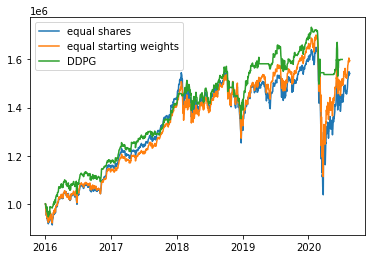

In [ ]:
# BASELINE STRATEGIES
# EQUALLY WEIGHTED
budget = 1_000_000
shares = data.loc[data.datadate == 20160104, ['tic', 'adjcp']]
shares['shares_ew'] = budget / len(shares) / shares['adjcp']  # equal weight / market value
shares['shares_es'] = budget / shares.adjcp.sum()  # equal share

trading_data = data.loc[data.datadate >= 20160104]
trading_data = trading_data.merge(shares[['tic', 'shares_ew', 'shares_es']], on='tic')
trading_data['market_value_ew'] = trading_data['adjcp'] * trading_data['shares_ew']
trading_data['market_value_es'] = trading_data['adjcp'] * trading_data['shares_es']
equal_starting_weights = trading_data.groupby('datadate')['market_value_ew'].sum()
equal_shares = trading_data.groupby('datadate')['market_value_es'].sum()
print(calculate_single_stats(equal_starting_weights))
print(calculate_single_stats(equal_shares))
equal_starting_weights.index = pd.to_datetime(equal_starting_weights.index, format='%Y%m%d')
equal_shares.index = pd.to_datetime(equal_shares.index, format='%Y%m%d')
#plt.plot(equal_shares, label='equal shares')
#plt.plot(equal_starting_weights, label='equal starting weights')

ddpg_best = process_trading_results('DDPG_MLP_wider_leaky_relu_TL140')
plt.plot(ddpg_best.mean(axis=1), label='DDPG')
plt.legend()

In [ ]:
ddpg_best = process_trading_results('DDPG_MLP_wider_leaky_relu_TL140')
#ddpg_best = ddpg_best.mean(axis=1)

ddpg_no_turbulence = process_trading_results('DDPG_MLP_default_relu_TL1000')
#ddpg_no_turbulence = ddpg_no_turbulence.mean(axis=1)

Text(0.5, 1.0, 'Cumulative Return with Transaction Cost')

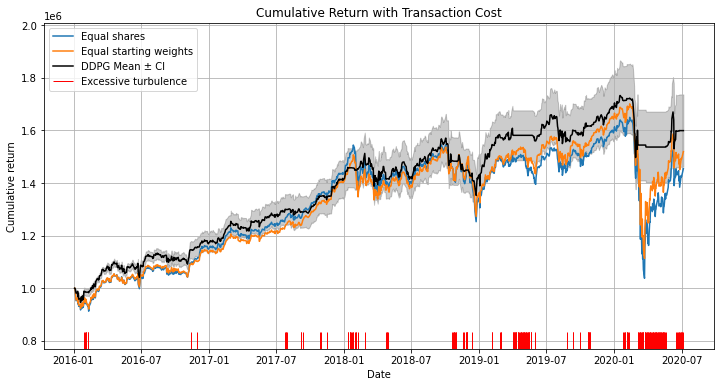

In [ ]:
plt.figure(figsize=(12, 6))
plt.grid()

trading_end_date = '2020-07-06'

benchmarks_df = pd.DataFrame()
equal_shares_shortened = equal_shares.loc[equal_shares.index <= trading_end_date].copy()
equal_starting_weights_shortened = equal_starting_weights.loc[equal_starting_weights.index <= trading_end_date].copy()

benchmarks_df = pd.concat([equal_shares_shortened, equal_starting_weights_shortened], axis=1)
benchmarks_df.columns = ['Equal shares', 'Equal starting weights']
benchmarks_df_melted = benchmarks_df.reset_index().melt(id_vars='datadate', var_name='Series', value_name='Value')
sns.lineplot(data=benchmarks_df_melted, x='datadate', y='Value', hue='Series', legend='full')

# best DDPG model 
ddpg_best_df = process_trading_results('DDPG_MLP_wider_leaky_relu_TL140')
ddpg_best_df_melted = ddpg_best_df.reset_index().melt(id_vars='datadate', var_name='Series', value_name='Value')
sns.lineplot(data=ddpg_best_df_melted, x='datadate', y='Value', ci='sd', color='black', label='DDPG Mean ± CI')

# turbulence feature is effectively turned off
#ddpg_no_turbulence_df = process_trading_results('DDPG_MLP_default_relu_TL1000')
#ddpg_no_turbulence_df_melted = ddpg_no_turbulence_df.reset_index().melt(id_vars='datadate', var_name='Series', value_name='Value')
#sns.lineplot(data=ddpg_no_turbulence_df_melted, x='datadate', y='Value', ci='sd', color='brown', label='DDPG No Turbulence Mean ± CI')

rug_data = process_turbulence_history('DDPG_MLP_wider_leaky_relu_TL140')
sns.rugplot(
    x=rug_data.loc[rug_data['is_above_threshold'], 'datadate'].values, 
    height=0.05, 
    color='red',
    label='Excessive turbulence'
)

plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.title('Cumulative Return with Transaction Cost')

In [492]:
benchmark_comparison = pd.concat([
    calculate_single_stats(equal_starting_weights).T,
    calculate_single_stats(equal_shares).T,
    pd.DataFrame(calculate_average_stats(ddpg_best_df)).T,
]).reset_index().rename(columns={'index': 'Method / Agent'})

benchmark_comparison['Method / Agent'] = [
    'Buy-and-hold | equally-weighted',
    'Buy-and-hold | equal number of shares',
    'DDPG | wider | leaky_relu | TL140'
]
benchmark_comparison = benchmark_comparison.sort_values(by='Sharpe ratio', ascending=False)
benchmark_comparison.insert(0, 'Rank', [1, 2, 3])
benchmark_comparison.iloc[:, 2:] = benchmark_comparison.iloc[:, 2:].apply(lambda x: [round(elem, 3) for elem in x])
benchmark_comparison

,Rank,Method / Agent,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Max drawdown
2,1,DDPG | wider | leaky_relu | TL140,0.109,0.600,0.122,0.912,-0.147
0,2,Buy-and-hold | equally-weighted,0.106,0.594,0.197,0.612,-0.346
1,3,Buy-and-hold | equal number of shares,0.098,0.541,0.204,0.562,-0.371


In [ ]:
# Align length to original paper
paper_end_date = '2020-05-08'
equal_shares_shortened = equal_shares.loc[equal_shares.index <= paper_end_date].copy()
equal_starting_weights_shortened = equal_starting_weights.loc[equal_starting_weights.index <= paper_end_date].copy()

benchmark_comparison = pd.concat([
    calculate_single_stats(equal_starting_weights_shortened).T,
    calculate_single_stats(equal_shares_shortened).T,
]).reset_index().rename(columns={'index': 'Method'})

benchmark_comparison['Method'] = [
    'Buy-and-hold | equally-weighted',
    'Buy-and-hold | equal number of shares',
]
benchmark_comparison = benchmark_comparison.sort_values(by='Sharpe ratio', ascending=False)
benchmark_comparison.insert(0, 'Rank', [1, 2])
benchmark_comparison.iloc[:, 2:] = benchmark_comparison.iloc[:, 2:].apply(lambda x: [round(elem, 3) for elem in x])
benchmark_comparison

,Rank,Method,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Max drawdown
0,1,Buy-and-hold | equally-weighted,0.085,0.423,0.195,0.515,-0.346
1,2,Buy-and-hold | equal number of shares,0.071,0.347,0.201,0.442,-0.371


In [345]:
from scipy.stats import ttest_1samp

mean_sharpe_ddpg = calculate_average_stats(ddpg_best_df)['Sharpe ratio']
sharpes = []
for col in ddpg_best_df.columns:
    sharpes.append(calculate_single_stats(ddpg_best_df[col]).loc['Sharpe ratio'].values[0])
  
mean_sharpe_buy_and_hold = benchmark_comparison.query(
  '`Method / Agent` == "Buy-and-hold | equally-weighted"'
)['Sharpe ratio'].values[0]

# Perform a one-sample t-test
t_stat, p_value = ttest_1samp(
  sharpes,
  mean_sharpe_buy_and_hold
)

# Since this is a one-tailed test, divide the p-value by 2
p_value_one_tailed = p_value / 2

# Print results
print(f"Mean Sharpe ratio (DDPG): {np.mean(sharpes):.3f}")
print(f"Standard error: {np.std(sharpes, ddof=1) / np.sqrt(30):.3f}")
print(f"Sharpe ratio (Buy-and-hold): {mean_sharpe_buy_and_hold:.3f}")
print(f"t-stat: {t_stat:.3f}")
print(f"One-tailed p-value: {p_value_one_tailed:.3f}")


Mean Sharpe ratio (DDPG): 0.912
Standard error: 0.031
Sharpe ratio (Buy-and-hold): 0.612
t-stat: 9.835
One-tailed p-value: 0.000


In [ ]:
# Calculating the z-scores of the original paper

#best_ddpg = process_trading_results('DDPG_MLP_wider_leaky_relu_TL140')
#best_ppo = process_trading_results('PPO_MLP_deeper_leaky_relu_TL140')
#best_a2c = process_trading_results('A2C_MLP_default_leaky_relu_TL140')
average_ddpg = process_trading_results('DDPG_MLP_default_relu_TL140')
average_ppo = process_trading_results('PPO_MLP_default_relu_TL140')
average_a2c = process_trading_results('A2C_MLP_default_relu_TL140')

orig_ppo = pd.Series(
    [0.15, 0.83, 0.136, 1.10, -0.237],
    index=[
        'Annual return', 'Cumulative returns', 'Annual volatility', 'Sharpe ratio', 'Max drawdown'
    ]
)
orig_a2c = pd.Series(
    [0.114, 0.6, 0.104, 1.12, -0.102],
    index=[
        'Annual return', 'Cumulative returns', 'Annual volatility', 'Sharpe ratio', 'Max drawdown'
    ]
)
orig_ddpg = pd.Series(
    [0.105, 0.548, 0.123, 0.87, -0.148],
    index=[
        'Annual return', 'Cumulative returns', 'Annual volatility', 'Sharpe ratio', 'Max drawdown'
    ]
)

zscores = []
for agent_name, best_model, orig_results in zip(
        ['a2c', 'ddpg', 'ppo'], [average_a2c, average_ddpg, average_ppo], [orig_a2c, orig_ddpg, orig_ppo]
    ):
    run_results = []
    for row in best_model.columns:
        run_results.append(
            calculate_single_stats(best_model[row])
        )
    means = pd.concat(run_results, axis=1).mean(axis=1)
    std_errors = pd.concat(run_results, axis=1).std(axis=1, ddof=1)
    zscore = pd.Series((orig_results - means) / std_errors, name=f'{agent_name}_z_scores').round(3)
    zscores.append(zscore)

In [405]:
zscore_df = pd.concat([
    pd.concat(map(calculate_average_stats, [average_a2c, average_ddpg, average_ppo]), axis=1).round(3),
    pd.concat([orig_a2c, orig_ddpg, orig_ppo], axis=1),
    pd.concat(zscores, axis=1)
], axis=1)
zscore_df.columns = [
    'Average A2C', 'Average DDPG', 'Average PPO',
    'Published A2C', 'Published DDPG', 'Published PPO',
    'A2C z-score', 'DDPG z-score', 'PPO z-score'
]
ordered_columns = (
    [col for col in zscore_df.columns if col.find('A2C') != -1] + 
    [col for col in zscore_df.columns if col.find('DDPG') != -1] + 
    [col for col in zscore_df.columns if col.find('PPO') != -1]
)
zscore_df[ordered_columns]


,Average A2C,Published A2C,A2C z-score,Average DDPG,Published DDPG,DDPG z-score,Average PPO,Published PPO,PPO z-score
Annual return,0.086,0.114,1.098,0.099,0.105,0.247,0.097,0.150,2.884
Cumulative returns,0.455,0.600,0.953,0.535,0.548,0.085,0.518,0.830,2.676
Annual volatility,0.127,0.104,-5.414,0.124,0.123,-0.165,0.126,0.136,2.190
Sharpe ratio,0.716,1.120,2.081,0.823,0.870,0.291,0.796,1.100,2.223
Max drawdown,-0.166,-0.102,2.832,-0.153,-0.148,0.287,-0.153,-0.237,-4.514


In [416]:
def top_results(results_df: pd.DataFrame, sort_values_by: str, ascending: bool = True, top_n: int = 10):
    results_df = (
        results_df.sort_values(sort_values_by, ascending=ascending)
                  .reset_index(drop=True)
                  .rename(columns={'Model name': 'Agent'})
    )
    results_df.insert(0, 'Rank', range(1, len(results_df) + 1))
    results_df.iloc[:, 5:] = results_df.iloc[:, 5:].round(3)
    return results_df.loc[
        results_df.Rank.isin(range(1, top_n + 1)),
        ['Rank', 'Agent', 'Architecture', 'Activation function', 'Annual return',
         'Cumulative returns', 'Annual volatility', 'Sharpe ratio']
    ]

top_results(results_df, 'Annual volatility')

,Rank,Agent,Architecture,Activation function,Annual return,Cumulative returns,Annual volatility,Sharpe ratio
0,1,PPO,MLP_shallower,tanh,0.053,0.263,0.096,0.583
1,2,PPO,MLP_deeper,tanh,0.054,0.268,0.098,0.583
2,3,PPO,MLP_default,tanh,0.062,0.313,0.099,0.658
3,4,PPO,MLP_wider,tanh,0.067,0.339,0.103,0.681
4,5,A2C,MLP_default,tanh,0.069,0.353,0.104,0.693
5,6,A2C,MLP_deeper,tanh,0.054,0.273,0.106,0.557
6,7,A2C,MLP_shallower,tanh,0.054,0.273,0.106,0.557
7,8,A2C,MLP_wider,tanh,0.075,0.390,0.110,0.720
8,9,DDPG,MLP_shallower,tanh,0.097,0.519,0.121,0.825
9,10,DDPG,MLP_default,leaky_relu,0.106,0.579,0.122,0.892


In [464]:
top_results(results_df, 'Sharpe ratio', ascending=False, top_n=100)

,Rank,Agent,Architecture,Activation function,Annual return,Cumulative returns,Annual volatility,Sharpe ratio
0,1,DDPG,MLP_wider,leaky_relu,0.109,0.600,0.122,0.912
1,2,DDPG,MLP_default,leaky_relu,0.106,0.579,0.122,0.892
2,3,DDPG,MLP_shallower,leaky_relu,0.106,0.578,0.123,0.883
3,4,DDPG,MLP_deeper,leaky_relu,0.104,0.562,0.124,0.861
4,5,DDPG,MLP_wider,tanh,0.102,0.555,0.122,0.859
5,6,DDPG,MLP_deeper,tanh,0.101,0.547,0.124,0.844
6,7,DDPG,MLP_wider,relu,0.101,0.547,0.124,0.840
7,8,DDPG,MLP_deeper,relu,0.100,0.538,0.124,0.833
8,9,DDPG,MLP_shallower,relu,0.098,0.531,0.123,0.826
9,10,DDPG,MLP_shallower,tanh,0.097,0.519,0.121,0.825


In [461]:
x = top_results(results_df, 'Cumulative returns', False, top_n=100)
x = x.drop(columns='Activation function').rename(columns={'Architecture': 'Approach'})
x.iloc[1, 2] = 'greedy'
x.iloc[:, 3:] = x.iloc[:, 3:].astype('float').round(3)
x

,Rank,Agent,Approach,Annual return,Cumulative returns,Annual volatility,Sharpe ratio
0,1,ensemble,non-greedy,0.116,0.642,0.129,0.915
1,2,ensemble,greedy,0.101,0.549,0.125,0.838


In [ ]:
# GREEDY / NON-GREEDY RESULTS
import os
import pandas as pd

def process_ensemble_results(model_name):
    run_trading_results = {}
    model_name = (
        'ensemble_non-greedy' if (model_name.find('non') != -1) & (model_name.find('greedy') != -1)
        else 'ensemble_default'
    )
    model_folder = os.path.join('results', model_name)
    for subfolder in os.listdir(model_folder):
        subfolder_path = os.path.join(model_folder, subfolder)

        # check if it's a folder indeed with a numeric name
        if os.path.isdir(subfolder_path) and subfolder.isdigit():
            trading_results_df = pd.DataFrame()

            # iterate through files in the subfolder
            for file in os.listdir(subfolder_path):
                # process only such csv files that contain trading data and are for the given model
                if file.startswith(f'account_value_trade_{model_name}') and file.endswith('.csv'):
                    file_path = os.path.join(subfolder_path, file)

                    # read the CSV file
                    df = pd.read_csv(file_path, usecols=['datadate', 'account_values'])

                    # combine the trading snapshot with existing outputs
                    if trading_results_df.empty:
                        trading_results_df = df
                    else:
                        trading_results_df = pd.concat([trading_results_df, df], axis=0)

            trading_results_df = trading_results_df.groupby('datadate', as_index=False)['account_values'].sum()
            trading_results_df.insert(0, 'run_id', int(subfolder))
            # check if any duplicates
            assert (
                len(trading_results_df) == len(trading_results_df.drop_duplicates())
            ), f'duplicated entries found in trading data for model "{model_name}"'

            # store the the results
            run_trading_results[int(subfolder)] = trading_results_df

    if len(run_trading_results) > 0:
        combined_df = pd.concat(run_trading_results.values()).reset_index(drop=True)
        combined_pivot = combined_df.pivot_table(
            index='datadate', columns='run_id', values='account_values'
        )
        # change dtype of datadate from int to datetime64
        combined_pivot = combined_pivot.set_index(pd.to_datetime(combined_pivot.index, format='%Y%m%d'))
    return combined_pivot

combined_pivot_greedy = process_ensemble_results('greedy')
combined_pivot_nongreedy = process_ensemble_results('non_greedy')


In [480]:
metric = 'Annual return'
greedy_sharpes = [
    calculate_single_stats(combined_pivot_greedy[col]).loc[metric].values[0]
    for col in combined_pivot_greedy.columns
]
nongreedy_sharpes = [
    calculate_single_stats(combined_pivot_nongreedy[col]).loc[metric].values[0]
    for col in combined_pivot_nongreedy.columns
]
bon_p = 0.05
stat, p_value = ttest_ind(greedy_sharpes, nongreedy_sharpes)
print(f"T-test: stat={stat:.3f}, p_value={p_value:.4f}", end=' ')
if p_value < bon_p:
    print(f"(<{bon_p:.4f}) * \n")
else:
    print(f"(>{bon_p:.4f})\n")

print(f"Mean greedy: {np.mean(greedy_sharpes):.3f}")
print(f"Mean nongreedy: {np.mean(nongreedy_sharpes):.3f}")
print(f"Standard error greedy: {np.std(greedy_sharpes, ddof=1) / np.sqrt(30):.3f}")
print(f"Standard error nongreedy: {np.std(nongreedy_sharpes, ddof=1) / np.sqrt(30):.3f}")

T-test: stat=-2.831, p_value=0.0064 (<0.0500) * 

Mean greedy: 0.101
Mean nongreedy: 0.116
Standard error greedy: 0.004
Standard error nongreedy: 0.003


In [445]:
pd.concat([
    pd.Series(calculate_average_stats(combined_pivot_nongreedy), name='Non-greedy'),
    pd.Series(calculate_average_stats(combined_pivot_greedy), name='Greedy'),
], axis=1)

,Non-greedy,Greedy
Annual return,0.116180,0.101421
Cumulative returns,0.642108,0.548950
Annual volatility,0.129230,0.124527
Sharpe ratio,0.915218,0.837957
Max drawdown,-0.180270,-0.152942


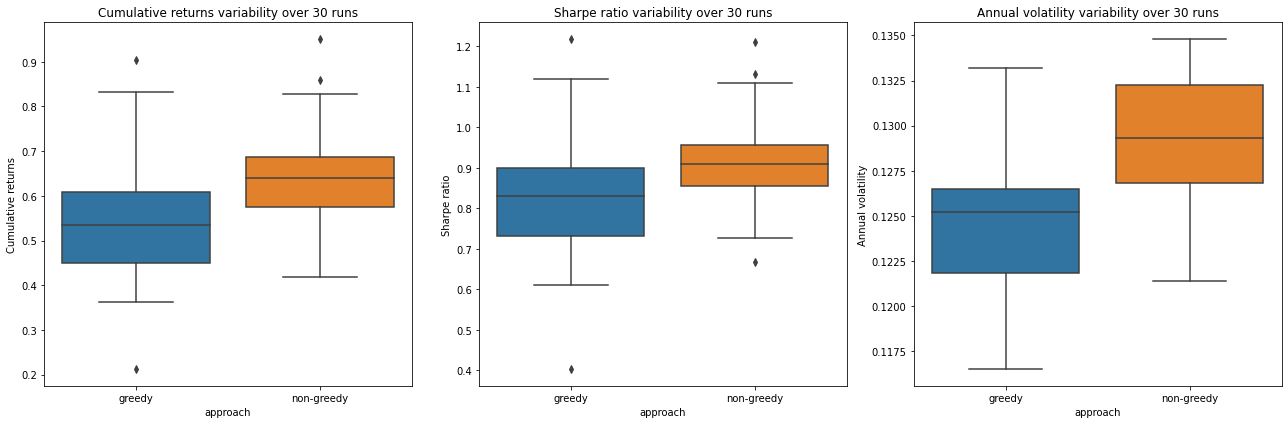

In [474]:
import seaborn as sns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs = axs.flatten()

ensemble_run_stats = {'greedy': [], 'non-greedy': []}
for col in range(1, 31):
    ensemble_run_stats['non-greedy'].append(calculate_single_stats(combined_pivot_nongreedy[col]))
    ensemble_run_stats['greedy'].append(calculate_single_stats(combined_pivot_greedy[col]))

for n, col in enumerate(['Cumulative returns', 'Sharpe ratio', 'Annual volatility']):
    run_df = (
        pd.DataFrame(ensemble_run_stats).applymap(lambda x: float(x.loc[col].values[0]))
                            .T
                            .reset_index(drop=False)
                            .rename(columns={'index': 'approach'})
    )
    run_df = pd.melt(run_df, id_vars=run_df.columns[:1], var_name='run_number', value_name=col)

    #title = 'Sharpe ratio' if n == 1 else 'Cumulative returns' + ' variability over 30 runs'
    title = col + ' variability over 30 runs'
    sns.boxplot(data=run_df, x='approach', y=col, ax=axs[n]).set_title(title)
plt.tight_layout()

Text(0.5, 1.0, 'Cumulative Return with Transaction Cost')

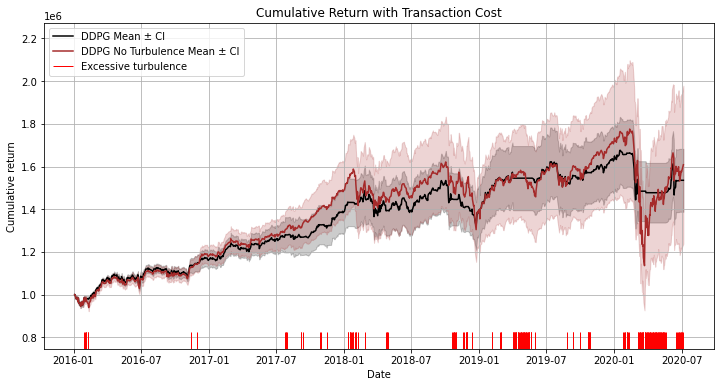

In [481]:
plt.figure(figsize=(12, 6))
plt.grid()

# best DDPG model 
ddpg_default_df = process_trading_results('DDPG_MLP_default_relu_TL140')
ddpg_default_df_melted = ddpg_default_df.reset_index().melt(id_vars='datadate', var_name='Series', value_name='Value')
sns.lineplot(data=ddpg_default_df_melted, x='datadate', y='Value', ci='sd', color='black', label='DDPG Mean ± CI')

# turbulence feature is effectively turned off
ddpg_no_turbulence_df = process_trading_results('DDPG_MLP_default_relu_TL1000')
ddpg_no_turbulence_df_melted = ddpg_no_turbulence_df.reset_index().melt(id_vars='datadate', var_name='Series', value_name='Value')
sns.lineplot(data=ddpg_no_turbulence_df_melted, x='datadate', y='Value', ci='sd', color='brown', label='DDPG No Turbulence Mean ± CI')

rug_data = process_turbulence_history('DDPG_MLP_wider_leaky_relu_TL140')
sns.rugplot(
    x=rug_data.loc[rug_data['is_above_threshold'], 'datadate'].values, 
    height=0.05, 
    color='red',
    label='Excessive turbulence'
)

plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative return')
plt.title('Cumulative Return with Transaction Cost')

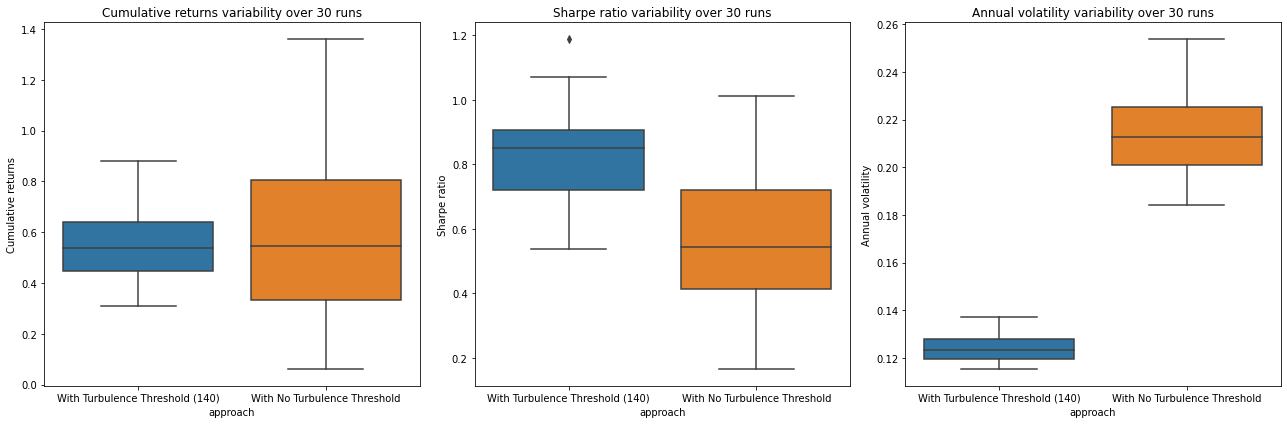

In [485]:
import seaborn as sns
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs = axs.flatten()

run_stats = {'With Turbulence Threshold (140)': [], 'With No Turbulence Threshold': []}
for col in range(1, 31):
    run_stats['With Turbulence Threshold (140)'].append(calculate_single_stats(ddpg_default_df[col]))
    run_stats['With No Turbulence Threshold'].append(calculate_single_stats(ddpg_no_turbulence_df[col]))

for n, col in enumerate(['Cumulative returns', 'Sharpe ratio', 'Annual volatility']):
    run_df = (
        pd.DataFrame(run_stats).applymap(lambda x: float(x.loc[col].values[0]))
                            .T
                            .reset_index(drop=False)
                            .rename(columns={'index': 'approach'})
    )
    run_df = pd.melt(run_df, id_vars=run_df.columns[:1], var_name='run_number', value_name=col)

    #title = 'Sharpe ratio' if n == 1 else 'Cumulative returns' + ' variability over 30 runs'
    title = col + ' variability over 30 runs'
    sns.boxplot(data=run_df, x='approach', y=col, ax=axs[n]).set_title(title)
plt.tight_layout()

In [496]:
from scipy.stats import ttest_1samp

mean_sharpe_no_turbulence = calculate_average_stats(ddpg_no_turbulence_df)['Sharpe ratio']
sharpes = []
for col in ddpg_no_turbulence_df.columns:
    sharpes.append(calculate_single_stats(ddpg_no_turbulence_df[col]).loc['Sharpe ratio'].values[0])
  
mean_sharpe_buy_and_hold = benchmark_comparison.query(
  '`Method / Agent` == "Buy-and-hold | equally-weighted"'
)['Sharpe ratio'].values[0]

# mean_sharpe_buy_and_hold = benchmark_comparison.query(
#   '`Method / Agent` == "Buy-and-hold | equal number of shares"'
# )['Sharpe ratio'].values[0]

# Perform a one-sample t-test
t_stat, p_value = ttest_1samp(
  sharpes,
  mean_sharpe_buy_and_hold
)

# Since this is a one-tailed test, divide the p-value by 2
p_value_one_tailed = p_value / 2

# Print results
print(f"Mean Sharpe ratio (DDPG): {np.mean(sharpes):.3f}")
print(f"Standard error: {np.std(sharpes, ddof=1) / np.sqrt(30):.3f}")
print(f"Sharpe ratio (Buy-and-hold): {mean_sharpe_buy_and_hold:.3f}")
print(f"t-stat: {t_stat:.3f}")
print(f"One-tailed p-value: {p_value_one_tailed:.3f}")


Mean Sharpe ratio (DDPG): 0.573
Standard error: 0.042
Sharpe ratio (Buy-and-hold): 0.612
t-stat: -0.926
One-tailed p-value: 0.181


In [494]:
benchmark_comparison

,Rank,Method / Agent,Annual return,Cumulative returns,Annual volatility,Sharpe ratio,Max drawdown
2,1,DDPG | wider | leaky_relu | TL140,0.109,0.600,0.122,0.912,-0.147
0,2,Buy-and-hold | equally-weighted,0.106,0.594,0.197,0.612,-0.346
1,3,Buy-and-hold | equal number of shares,0.098,0.541,0.204,0.562,-0.371


In [ ]:
process_turbulence_history('test').head()

,datadate,turbulence_level,turbulence_threshold,is_above_threshold
0,2016-07-05,67.638618,140,False
1,2016-07-06,71.093442,140,False
2,2016-07-07,66.458186,140,False
3,2016-07-08,59.252159,140,False
4,2016-07-11,57.581600,140,False


In [230]:
model_name = 'PPO_defaultMLP_turbulence_level_140'
model_folder = os.path.join('results', model_name)

bins = [0] + list(range(1, 100002, 2000))
results_dict = {f'{s}-{e-1}': [] for s, e in zip(bins[1:-1], bins[2:])}


for subfolder in os.listdir(model_folder):
    subfolder_path = os.path.join(model_folder, subfolder)
    tempcondition = int(subfolder) != 1
    if os.path.isdir(subfolder_path) and subfolder.isdigit() and tempcondition:
            # iterate through files in the subfolder
            for file in os.listdir(subfolder_path):
                # process only such csv files that contain trading data and are for the given model
                if file.startswith(f'account_value_train_{model_name}') and file.endswith('.csv'):
                    file_path = os.path.join(subfolder_path, file)
                    df = pd.read_csv(file_path)
                    cols = ['datadate'] + [col for col in df.columns if col[:7] == 'episode']
                    df = df[cols].set_index('datadate')
                    # strip out the episode numbers
                    cols = [int(col) * len(df) for col in df.columns.str.split('_').str.get(1)]                    
                    labels = [f"{start}-{end-1}" for start, end in zip(bins[:-1], bins[1:])]

                    # translate episode numbers into stepnumber buckets
                    cols = pd.cut(pd.Series(cols), bins=bins, labels=labels, right=False)
                    df.columns = cols
                    # get the last date
                    res = df.iloc[-1, :]
                    res = res.sort_values(ascending=False).reset_index().rename(columns={'index': 'bins'})
                    res['bins'] = res.bins.astype(str)

                    # register rankings for each bucket
                    for row in res.itertuples():
                        results_dict[row.bins].append(row.Index)

# a = pd.read_csv(f'results/A2C_defaultMLP_turbulence_level_140/{i}/account_value_train_A2C_defaultMLP_turbulence_level_140_20090102_20151231.csv')
# cols = [col for col in a.columns if col[0] == 'e']
# a = a[cols].set_index(pd.to_datetime(a['datadate'], format='%Y%m%d'))
# plt.figure(figsize=(14, 8))
# plt.plot(a)

In [234]:
lst = []
min_mean = np.inf
best_range = None
for key in results_dict:
    print(f'Range: {key} | Average ranking: {np.mean(results_dict[key])}')
    if np.mean(results_dict[key]) < min_mean:
        min_mean = np.mean(results_dict[key])
        best_range = key
    lst.append(np.mean(results_dict[key]))

Range: 1-2000 | Average ranking: 41.737931034482756
Range: 2001-4000 | Average ranking: 33.53639846743295
Range: 4001-6000 | Average ranking: 29.61111111111111
Range: 6001-8000 | Average ranking: 28.185344827586206
Range: 8001-10000 | Average ranking: 27.54022988505747
Range: 10001-12000 | Average ranking: 26.92528735632184
Range: 12001-14000 | Average ranking: 25.49290060851927
Range: 14001-16000 | Average ranking: 25.334051724137932
Range: 16001-18000 | Average ranking: 25.211494252873564
Range: 18001-20000 | Average ranking: 24.86815415821501
Range: 20001-22000 | Average ranking: 25.150862068965516
Range: 22001-24000 | Average ranking: 24.047892720306514
Range: 24001-26000 | Average ranking: 24.286637931034484
Range: 26001-28000 | Average ranking: 23.55578093306288
Range: 28001-30000 | Average ranking: 24.19612068965517
Range: 30001-32000 | Average ranking: 22.504310344827587
Range: 32001-34000 | Average ranking: 23.128352490421456
Range: 34001-36000 | Average ranking: 22.4804597701

In [235]:
best_range

'80001-82000'

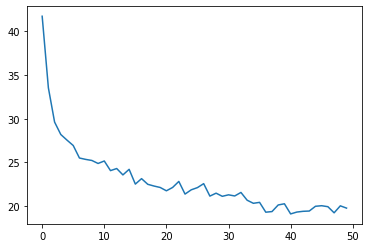

In [ ]:
pd.Series(lst).plot()

,bins,20171002
0,6001-9000,4.013065e+06
1,27001-30000,3.614804e+06
2,21001-24000,3.360973e+06
3,15001-18000,3.318363e+06
4,12001-15000,3.251891e+06
5,24001-27000,2.641313e+06
6,6001-9000,2.619148e+06
7,15001-18000,2.571343e+06
8,24001-27000,2.457432e+06
9,9001-12000,2.446025e+06


In [186]:
for row in res.itertuples():
    results_dict[row.bins].append(row.Index)

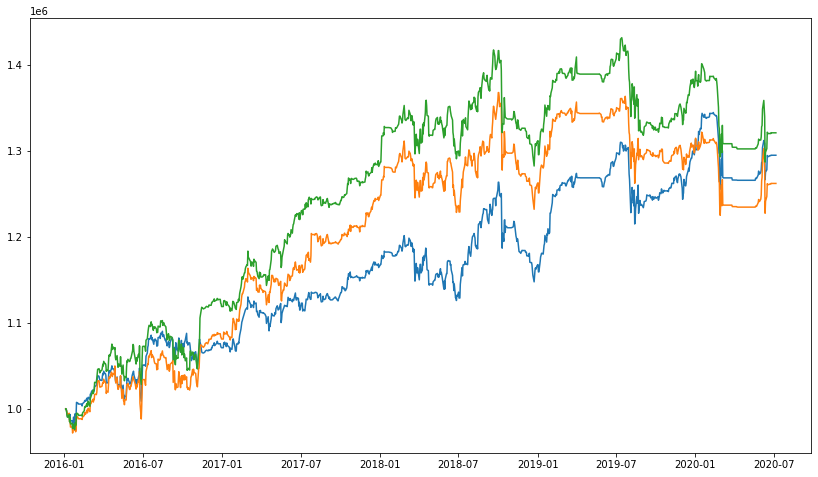

In [ ]:
%matplotlib inline
combined_pivot = process_trading_results('test')
plt.figure(figsize=(14, 8))
for run in combined_pivot.columns:
    plt.plot(combined_pivot[run], label=run)

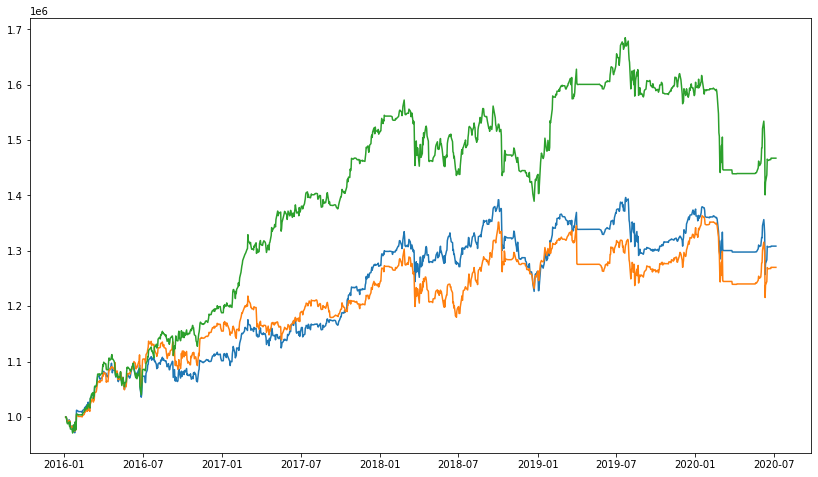

In [14]:
%matplotlib inline
combined_pivot = process_trading_results('A2C_default')
combined_pivot = combined_pivot.iloc[:, :3]
plt.figure(figsize=(14, 8))
for run in combined_pivot.columns:
    plt.plot(combined_pivot[run], label=run)

In [210]:
import os

# Set the parent directory
for i in range(1, 31):
    parent_dir = f"results/A2C_MLP_wider_tanh_TL140/{i}"

    # Walk through all subdirectories
    for root, dirs, files in os.walk(parent_dir):
        for file in files:
            if "_relu_" in file:
                old_path = os.path.join(root, file)
                new_file = file.replace("_relu_", "_tanh_")
                new_path = os.path.join(root, new_file)
                os.rename(old_path, new_path)
                print(f'Renamed: {old_path} -> {new_path}')


Renamed: results/A2C_MLP_wider_tanh_TL140/1/turbulence_history_A2C_MLP_wider_relu_TL140_20181003_20190103.csv -> results/A2C_MLP_wider_tanh_TL140/1/turbulence_history_A2C_MLP_wider_tanh_TL140_20181003_20190103.csv
Renamed: results/A2C_MLP_wider_tanh_TL140/1/account_value_trade_A2C_MLP_wider_relu_TL140_20200406_20200706.png -> results/A2C_MLP_wider_tanh_TL140/1/account_value_trade_A2C_MLP_wider_tanh_TL140_20200406_20200706.png
Renamed: results/A2C_MLP_wider_tanh_TL140/1/account_value_trade_A2C_MLP_wider_relu_TL140_20171003_20180102.csv -> results/A2C_MLP_wider_tanh_TL140/1/account_value_trade_A2C_MLP_wider_tanh_TL140_20171003_20180102.csv
Renamed: results/A2C_MLP_wider_tanh_TL140/1/account_value_train_A2C_MLP_wider_relu_TL140_20090102_20160404.png -> results/A2C_MLP_wider_tanh_TL140/1/account_value_train_A2C_MLP_wider_tanh_TL140_20090102_20160404.png
Renamed: results/A2C_MLP_wider_tanh_TL140/1/turbulence_history_A2C_MLP_wider_relu_TL140_20180405_20180703.csv -> results/A2C_MLP_wider_tan

In [211]:
{
    'a': 1,
    # ha
    'b': 2
}

{'a': 1, 'b': 2}